__Вводные данные:__

C целью определить лучший баннер в мобильном приложении, тестовой группе пользователей была предложена версия с другим цветовым решением с одинаковой возможность покупки платного функционала. A/B-тест был проведен в период с 08.05.2019 по 09.05.2019. 

__Задача:__

Необходимо оценить, какой из вариантов баннера является более предпочтительным для пользователей из региона US.

__Данные:__

__`Таблица Users`__:
- `UserID` – идентификационный номер пользователей;
- `Country` – регион продажи;
- `Group` – тип исследуемой группы.

__`Таблица Revenue`__:

- `UserID` – идентификационный номер пользователей;
- `Date` – дата просмотра пользователем баннера;
- `Revenue` – выручка от приобретения пользователем платного функционала, BYN
---

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import f
from scipy.stats import shapiro
from scipy.stats import norm
from datetime import datetime
from tqdm.auto import tqdm

In [151]:
sns.set()

In [3]:
users = pd.read_excel('result.xlsx', sheet_name=1, usecols='A:C', nrows=40000, names=['user_id', 'country', 'group'], dtype={'user_id': np.int_}, keep_default_na=False)
revenue = pd.read_excel('result.xlsx', sheet_name=1, usecols='F:H', nrows=378525, names=['user_id', 'date', 'revenue'], dtype={'user_id': np.int_, 'date': datetime, 'revenue': np.float_})

In [210]:
# выборка данных согласно задаче и их объединение
users_US = users[users.country == 'US'] 
revenue_ab = revenue[(revenue.date == datetime(2019, 5, 8)) | (revenue.date == datetime(2019, 5, 9))]

ab_test = (pd.merge(users_US[['user_id', 'group']], revenue_ab[['user_id', 'revenue']], on='user_id')).groupby(['user_id', 'group'], as_index=False).sum()
control_group = ab_test.loc[ab_test.group == 'Control', 'revenue']
target_group = ab_test.loc[ab_test.group == 'Target', 'revenue']

In [219]:
print(f"ARPPU контрольной группы: {control_group.mean():.2f}")
print(f"ARPPU тестовой группы: {target_group.mean():.2f}")

ARPPU контрольной группы: 56.91
ARPPU тестовой группы: 61.99


Как видно из расчетов, __новый баннер__ оказался __предпочтительнее__ - прирост на __5.07 BYN__. Подтвердим данную гипотезу статистически (что результаты не случайны).

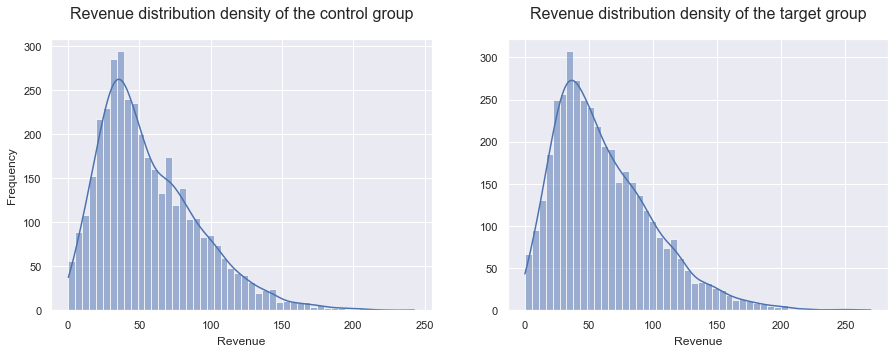

In [222]:
fig1 = plt.figure(figsize=(15, 5))

ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)


sns.histplot(control_group, bins=50, ax=ax1, kde=True)
sns.histplot(target_group, bins=50, ax=ax2, kde=True)


ax1.set_xlabel('Revenue', fontsize=12, labelpad=6)
ax1.set_ylabel('Frequency', fontsize=12, labelpad=6)
ax2.set_xlabel('Revenue', fontsize=12, labelpad=6)
ax2.set_ylabel('', fontsize=12, labelpad=6)

ax1.set_title('Revenue distribution density of the control group', fontsize=16, pad=20)
ax2.set_title('Revenue distribution density of the target group', fontsize=16, pad=20);

Явная ассиметрия распредлений не позволяет говорить об их нормальности. Однако важна на самом деле нормальность статистики (в данном случае - разница средних значений двух выборок). Поэтому

In [207]:
mean_diff = []
for i in tqdm(range(1000)):
    sample_control = control_group.sample(100).values
    sample_target = target_group.sample(100).values
    mean_diff.append(np.mean(sample_control - sample_target))

  0%|          | 0/1000 [00:00<?, ?it/s]

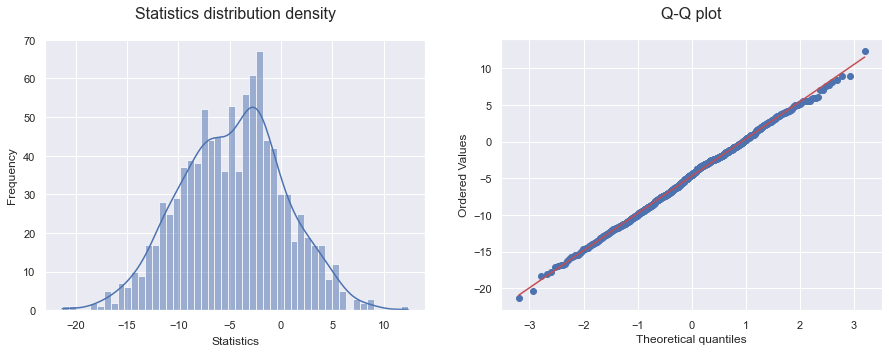

In [221]:
fig2 = plt.figure(figsize=(15, 5))

ax3 = fig2.add_subplot(121)
ax4 = fig2.add_subplot(122)


sns.histplot(mean_diff, bins=50, ax=ax3, kde=True)
sts.probplot(mean_diff, dist='norm', plot=ax4)


ax3.set_xlabel('Statistics', fontsize=12, labelpad=6)
ax3.set_ylabel('Frequency', fontsize=12, labelpad=6)

ax3.set_title('Statistics distribution density', fontsize=16, pad=20)
ax4.set_title('Q-Q plot', fontsize=16, pad=20);

In [223]:
shpr = shapiro(mean_diff)
print(f"W = {shpr[0]:.3f}, p-value = {shpr[0]:.3f}")

W = 0.998, p-value = 0.998


Графики и рассчитанные выше цифры позволяют применить тест Стьюдента для сравнения средних контрольной и тестовой групп:  

In [225]:
# тест Фишера на гомогенность дисперсий
F = np.var(control_group) / np.var(target_group)
df1 = len(control_group) - 1
df2 = len(target_group) - 1
p_value = f.cdf(F, df1, df2)

bool_F = True if p_value > 0.05 else False

In [226]:
tt = ttest_ind(target_group, control_group, equal_var=bool_F, alternative='greater')
print(f"t = {tt[0]:.3f}, p-value = {tt[1]:.12f}")

t = 6.112, p-value = 0.000000000517


In [227]:
def get_bootstrap(data_1, data_2):
    boot_len = max([len(data_1), len(data_2)])
    boot_data = []
    for _ in tqdm(range(1000)):
        samples_1 = data_1.sample(boot_len, replace=True).values
        samples_2 = data_2.sample(boot_len, replace=True).values
        boot_data.append(np.mean(samples_1 - samples_2))
    df_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - 0.95) / 2
    right_quant = 1 - (1 - 0.95) / 2
    quants = df_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=(-np.mean(boot_data)), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    return {"quants": quants, "p_value": p_value}

In [242]:
btstrp = get_bootstrap(target_group, control_group)
print(f"p-value: {btstrp['p_value']:.12f}")
print(f"0.025 quantile: {btstrp['quants'].iloc[0][0]:.2f}")
print(f"0.975 quantile: {btstrp['quants'].iloc[1][0]:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

p-value: 0.000000000587
0.025 quantile: 3.39
0.975 quantile: 6.62


Показатели теста Стьюдента и бутстрэпа позволяют смело отменить гипотезу о равенстве средних контрольной и тестовой групп.

А доверительный интервал для разницы составил - $P(3.39 \leq 5.07 \leq 6.62) = 95\%$

__Новый баннер действительно оказался предпочтительнее.__